#AAV genome size regression algorithm

1. Retrieve Data

*   This can be done using CPU
*   Change the query for your specific organism
*   Alternate AAs will be converted based on the 'amino_acid_map'. All possible sequences are added to the dataset

In [ ]:
import pandas as pd
from Bio import Entrez, SeqIO
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set your email for NCBI
Entrez.email = "-------"

# Define amino acid map for ambiguous characters
amino_acid_map = {
    'B': ['D', 'N'], 'Z': ['E', 'Q'], 'X': ['G'], 'J': ['L', 'I'],
    'U': ['C'], 'O': ['K']
}

def clean_sequence(sequence):
    sequence_variations = [[]]
    for aa in sequence:
        if aa in amino_acid_map:
            sequence_variations = [prev_seq + [replacement_aa]
                                   for prev_seq in sequence_variations
                                   for replacement_aa in amino_acid_map[aa]]
        else:
            sequence_variations = [prev_seq + [aa] for prev_seq in sequence_variations]
    return [''.join(seq) for seq in sequence_variations]

def search_viruses(batch_size=500):
    query = '("Parvoviridae"[Organism] OR "Parvovirinae"[Organism]) AND "complete genome"[All Fields]'
    all_ids = []
    start = 0

    while True:
        # Fetch a batch of results
        handle = Entrez.esearch(db="nuccore", term=query, retmax=batch_size, retstart=start)
        record = Entrez.read(handle)
        handle.close()

        # Add the IDs from the current batch to the list
        all_ids.extend(record["IdList"])

        # Check if we've retrieved all results
        if len(all_ids) >= int(record["Count"]):
            break

        # Move to the next batch
        start += batch_size

    return all_ids

def fetch_sequences(id_list):
    data = []
    try:
        handle = Entrez.efetch(db="nuccore", id=','.join(id_list), rettype="gb", retmode="text")
        records = list(SeqIO.parse(handle, "genbank"))
        handle.close()
    except Exception as e:
        print(f"Error fetching sequences: {e}")
        return pd.DataFrame()

    for record in records:
        len_genome = len(record.seq)
        virus_name = record.description.split(',')[0]
        if 'unverified' in virus_name.lower():
            continue

        capsid_proteins = []
        for feature in record.features:
            if feature.type == "CDS" and "product" in feature.qualifiers:
                product_name = feature.qualifiers["product"][0]
                if any(kw in product_name.lower() for kw in ["cap", "structural", "vp", "coat"]) and not any(
                        kw in product_name.lower() for kw in ["nonstructural", "non-structural"]):
                    protein_id = feature.qualifiers.get('protein_id', [None])[0]
                    capsid_seq = feature.qualifiers.get("translation", [""])[0]
                    capsid_proteins.append((product_name, protein_id, capsid_seq))

        for product_name, protein_id, capsid_seq in capsid_proteins:
            if any(aa in capsid_seq for aa in amino_acid_map.keys()):
                possible_sequences = clean_sequence(capsid_seq)
                for i, seq in enumerate(possible_sequences, start=1):
                    data.append({
                        "Virus": virus_name,
                        "Product": f"{product_name}.var_{i}",
                        "Accession": record.id,
                        "Genome_Length": len_genome,
                        "Protein_ID": f"{protein_id}.var_{i}",
                        "capsid_sequence": seq
                    })
            else:
                data.append({
                    "Virus": virus_name,
                    "Product": product_name,
                    "Accession": record.id,
                    "Genome_Length": len_genome,
                    "Protein_ID": protein_id,
                    "capsid_sequence": capsid_seq
                })

    return pd.DataFrame(data)

# Search and fetch sequences
virus_ids = search_viruses()
df = fetch_sequences(virus_ids)
df = df[df['Genome_Length'] >= 3000]

# Save to Google Drive
csv_file_path = '/content/drive/My Drive/parvoviridae_all_data.csv'
df.to_csv(csv_file_path, index=False)
print(f"Data saved successfully! Total entries: {len(df)}")
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saved successfully! Total entries: 3856
                                      Virus                 Product  \
0  Myzus persicae densovirus isolate Colmar  VP2-VP1 fusion protein   
1  Myzus persicae densovirus isolate Colmar      virion protein VP1   
2  Myzus persicae densovirus isolate Colmar      VP1 splice variant   
3  Myzus persicae densovirus isolate Colmar      virion protein VP2   
4    Goose parvovirus isolate GPV-AH-JQ2024          capsid protein   

    Accession  Genome_Length  Protein_ID  \
0  PQ247848.1           5873  XHB39173.1   
1  PQ247848.1           5873  XHB39170.1   
2  PQ247848.1           5873  XHB39174.1   
3  PQ247848.1           5873  XHB39171.1   
4  PQ536887.1           5046  XKT66753.1   

                                     capsid_sequence  
0  MSSVNDEFYSVEEENNERKRIKLGASGTSNEGITWFGSSFVGPGNL...  
1  MREFRYLGPPPPERANWQNLN

2. ESM transformer


*   Run on A100 GPU. High RAM not needed
*   Because of large capsid size, can only run the esm2_t33_650M_UR50D model

In [ ]:
#Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 22 20:24:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#Read in csv
csv_file_path = '/content/drive/My Drive/parvoviridae_all_data.csv'
df = pd.read_csv(csv_file_path)

#Check if Accessions unique
if df['Protein_ID'].is_unique:
    print("Protein_ID column is unique, good to go.")
else:
    print("Warning: Protein_ID column is not unique. Consider de-duplicating or using another key. Running sequences one at a time is okay")

Mounted at /content/drive
Protein_ID column is unique, good to go.


In [ ]:
!pip install fair-esm
import torch
import esm
import pandas as pd

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ESM model and alphabet
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device)  # Move the model to the GPU or CPU based on availability
batch_converter = alphabet.get_batch_converter()
model.eval()  # Disables dropout for deterministic results

# Prepare data
data = list(zip(df['Protein_ID'], df['capsid_sequence']))

def get_embeddings(sequence, id):
    """
    Generate sequence representation for a single amino acid sequence using the ESM model
    and predict the genome size using a pre-trained XGBoost regression model.

    Args:
    sequence (str): The amino acid sequence.

    Returns:
    predicted_genome_size (float): The predicted genome size from the regression model.
    """
    # Prepare the input in the format expected by the ESM model
    batch_data = [(id, sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
    batch_tokens = batch_tokens.to(device)  # Move the tokens to the same device as the model
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations from the transformer model
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33].cpu()  # Move to CPU for further processing

    # Generate per-sequence representation via averaging (for a single sequence)
    sequence_representation = token_representations[0, 1 : batch_lens[0] - 1].mean(0).numpy()

    return sequence_representation

sequence_representations = []

# Generate sequence representations for each sequence in the DataFrame
for id, seq in data:
    sequence_representation = get_embeddings(seq, id)
    sequence_representations.append(sequence_representation)


# Store the sequence representations in the DataFrame
df['sequence_representation'] = sequence_representations

# Save the DataFrame as a Pickle file
pickle_file_path = '/content/drive/My Drive/parvoviridae_all_embeddings.pkl'
df.to_pickle(pickle_file_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.5 MB/s eta 0:00:00


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


3. PCA
*   Can be run on CPU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Category Counts:
Parvoviridae VP1: 1371
Parvoviridae capsid: 1115
Parvoviridae VP2: 1085
AAV VP1: 79
AAV VP2: 75
AAV VP3: 75
Parvoviridae VP3: 30
AAV capsid: 26


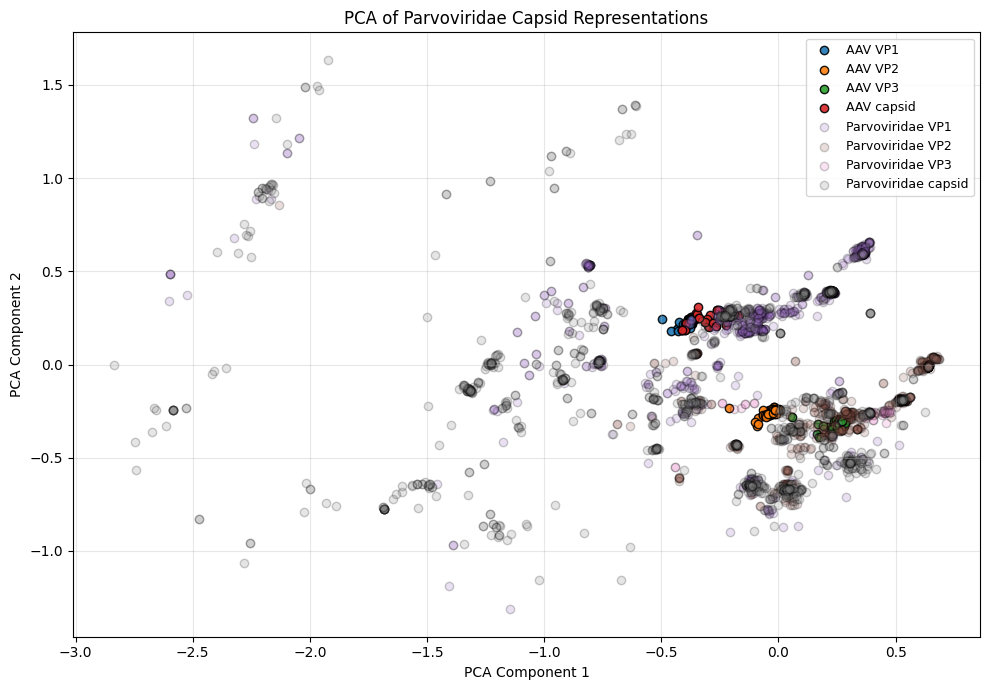

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Mount Google Drive
drive.mount('/content/drive')

# Load your DataFrame
df = pd.read_pickle('/content/drive/My Drive/parvoviridae_all_embeddings.pkl')
df.reset_index(drop=True, inplace=True)

# Define the categorization function
def categorize_virus(virus, product):
    species = virus.lower()
    protein = product.lower()

    # Categorize Human AAV
    if 'adeno-associated' in species or 'aav' in species:
        if 'vp1' in protein:
            return 'AAV VP1'
        elif 'vp2' in protein:
            return 'AAV VP2'
        elif 'vp3' in protein:
            return 'AAV VP3'
        else:
            return 'AAV capsid'

    # Categorize other Parvovirinae
    else:
        if 'vp1' in protein:
            return 'Parvoviridae VP1'
        elif 'vp2' in protein:
            return 'Parvoviridae VP2'
        elif 'vp3' in protein:
            return 'Parvoviridae VP3'
        else:
            return 'Parvoviridae capsid'

# Apply the categorization function to both Virus and Product columns
df['category'] = df.apply(lambda row: categorize_virus(row['Virus'], row['Product']), axis=1)

# Count the number of entries in each category
category_counts = df['category'].value_counts()

# Print the counts for each category
print("Category Counts:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

# Convert sequence representations to a 2D array for PCA
sequence_representations = np.stack(df['sequence_representation'].values, axis=0)

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(sequence_representations)

# Define categories and improved colors for each group
categories = ['AAV VP1', 'AAV VP2', 'AAV VP3', 'AAV capsid',
              'Parvoviridae VP1', 'Parvoviridae VP2', 'Parvoviridae VP3', 'Parvoviridae capsid']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']  # Matplotlib color codes

# Define alpha values for highlighting
alpha_values = [0.9, 0.9, 0.9, 0.9, 0.2, 0.2, 0.2, 0.2]  # Higher alpha for AAV, lower for Parvoviridae

# Plot the PCA result
plt.figure(figsize=(10, 7))

# Plot each category with corresponding color, label, and alpha
for category, color, alpha in zip(categories, colors, alpha_values):
    subset = df[df['category'] == category]
    plt.scatter(X_pca[subset.index, 0], X_pca[subset.index, 1],
                c=color, label=category, alpha=alpha, edgecolor='k')

# Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Parvoviridae Capsid Representations')
plt.legend(loc='best', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


4. Regression Model
*   Run on T4 runtime to save compute hours

In [ ]:
#Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 22 21:24:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Hyperparameter Tuning with K-folds CV

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from itertools import product
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load your DataFrame
df = pd.read_pickle('/content/drive/My Drive/parvoviridae_all_embeddings.pkl')

# Define X and y
X = np.stack(df['sequence_representation'].values, axis=0)
y = df['Genome_Length'].values

# Hyperparameter grid
param_grid = {
    'n_estimators': [250, 500, 750, 1000],
    'max_depth': [3, 5, 7, 10]
}

# Create all parameter combinations
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth']
))

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Track best result
best_model = None
best_params = None
best_rmse = float('inf')

# Loop through parameter combinations
for n_estimators, max_depth in param_combinations:
    # Initialize the XGBoost model
    xgb_model = XGBRegressor(
        n_estimators= n_estimators,
        max_depth= max_depth,
        learning_rate= 0.01,
        alpha= 1,
        reg_lambda= 0.1,
        random_state=42,
        tree_method='hist',  # Use histogram-based training
        device='cuda',       # Use GPU for training
        eval_metric='rmse'
    )

    # Cross-validation
    cv_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Fit model
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # Predict using GPU
        y_pred = xgb_model.predict(X_val)
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
        cv_scores.append(rmse)

    mean_rmse = np.mean(cv_scores)

    # Update best model if current parameters are better
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth
        }
        best_model = xgb_model



# Print the best result
print("\nBest Parameters:")
print(best_params)
print(f"Mean RMSE: {best_rmse:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Best Parameters:
{'n_estimators': 1000, 'max_depth': 5}
Mean RMSE: 207.9278


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load your DataFrame
df = pd.read_pickle('/content/drive/My Drive/parvoviridae_all_embeddings.pkl')

# Define X and y
X = np.stack(df['sequence_representation'].values, axis=0)
y = df['Genome_Length'].values

# Parameters for the model
params = {
    'n_estimators': 1500,
    'max_depth': 5,
    'learning_rate': 0.02,
    'alpha': 10,
    'reg_lambda': 1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda',  # Use GPU for training
    'eval_metric': 'rmse'
}

# Initialize the model
xgb_model = XGBRegressor(**params)

# Set up K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = []
fold = 1
for train_idx, val_idx in kf.split(X):
    print(f"Starting Fold {fold}...")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Train the model
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict and calculate RMSE for this fold
    y_pred = xgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_scores.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    fold += 1

# Calculate mean and standard deviation of RMSE across folds
mean_rmse = np.mean(cv_scores)
std_rmse = np.std(cv_scores)

# Print CV results
print("\nCross-Validation Results:")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting Fold 1...
Fold 1 RMSE: 203.8109
Starting Fold 2...
Fold 2 RMSE: 230.0603
Starting Fold 3...
Fold 3 RMSE: 193.3767
Starting Fold 4...
Fold 4 RMSE: 176.6142
Starting Fold 5...
Fold 5 RMSE: 197.0916

Cross-Validation Results:
Mean RMSE: 200.1908
Standard Deviation of RMSE: 17.4194


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train RMSE: 105.3432
Validation RMSE: 203.6749


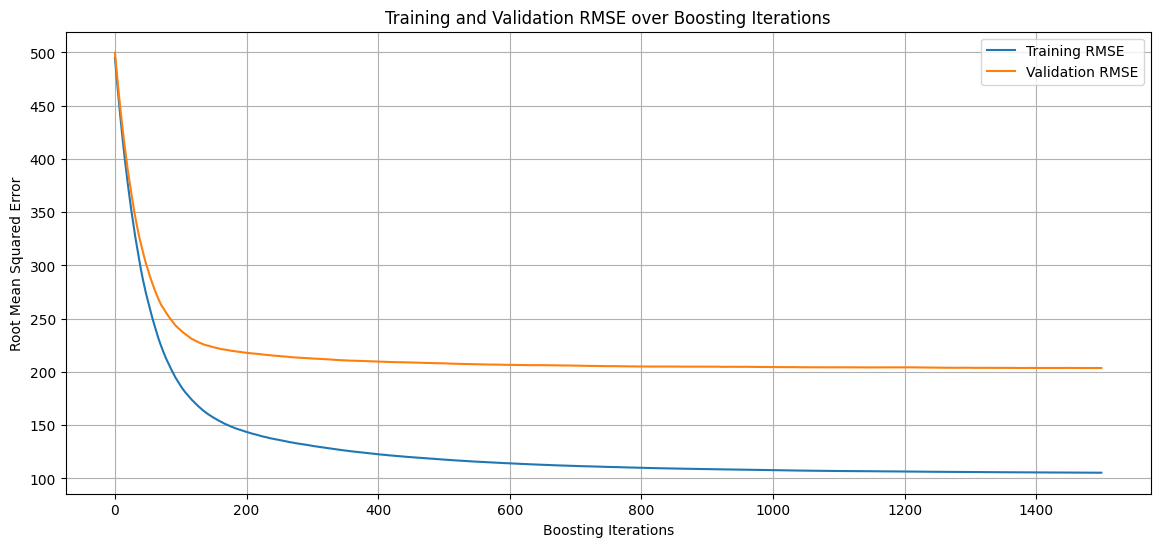

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from google.colab import drive
import pandas as pd
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Load your DataFrame
df = pd.read_pickle('/content/drive/My Drive/parvoviridae_all_embeddings.pkl')

# Define X and y
X = np.stack(df['sequence_representation'].values, axis=0)
y = df['Genome_Length'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model parameters
params = {
    'n_estimators': 1500,
    'max_depth': 5,
    'learning_rate': 0.02,
    'alpha': 10,
    'reg_lambda': 1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda',  # Use GPU for training
    'eval_metric': 'rmse'
}

# Initialize the XGBoost model
final_model = XGBRegressor(**params)

# Train the model and time the training process
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False  # Set to True to see the training progress
)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, final_model.predict(X_train))
val_rmse = root_mean_squared_error(y_val, final_model.predict(X_val))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Plot the validation and training errors over boosting iterations
results = final_model.evals_result()
train_errors = results['validation_0']['rmse']
val_errors = results['validation_1']['rmse']

plt.figure(figsize=(14, 6))
plt.plot(train_errors, label="Training RMSE")
plt.plot(val_errors, label="Validation RMSE")
plt.xlabel("Boosting Iterations")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training and Validation RMSE over Boosting Iterations")
plt.grid(True)
plt.show()



In [ ]:
# Save the model to a file
final_model.save_model('/content/drive/My Drive/parvoviridae_xgb_model.json')

1. Velocity-based AAV generation model
- Finds local best mutation at each step

In [ ]:
!pip install biopython
!pip install fair-esm
import torch
import esm
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import math
from google.colab import drive
import time
from Bio import Entrez, SeqIO
from datetime import datetime

drive.mount('/content/drive')

# Define amino acid alphabet (excluding any non-standard amino acids)
amino_acids = 'ARNDCEQGHILKMFPSTWYV'

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ESM model and alphabet
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device)  # Move the model to the GPU or CPU based on availability
batch_converter = alphabet.get_batch_converter()
model.eval()  # Disable dropout for deterministic results

# Load your saved XGBoost model
xgb_model = XGBRegressor()
xgb_model.load_model('/content/drive/My Drive/parvoviridae_xgb_model.json')

def predict_sequence(sequence):
    """
    Generate sequence representation for a single amino acid sequence using the ESM model
    and predict the genome size using a pre-trained XGBoost regression model.

    Args:
    sequence (str): The amino acid sequence.

    Returns:
    predicted_genome_size (float): The predicted genome size from the regression model.
    """
    # Prepare the input in the format expected by the ESM model
    batch_data = [("seq", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
    batch_tokens = batch_tokens.to(device)  # Move the tokens to the same device as the model
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations from the transformer model
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33].cpu()  # Move to CPU for further processing

    # Generate per-sequence representation via averaging (for a single sequence)
    sequence_representation = token_representations[0, 1 : batch_lens[0] - 1].mean(0).numpy()

    # Reshape sequence_representation for the regression model (1, -1) ensures 2D input
    sequence_representation = sequence_representation.reshape(1, -1)

    # Run the regression model on the sequence representation
    predicted_genome_size = xgb_model.predict(sequence_representation)

    return predicted_genome_size[0]  # Return the predicted genome size


# Function to initialize the mutation matrix using precomputed values
def initialize_mut_matrix(sequence, mutation_regions, mut_matrix = None):
    n = len(sequence)
    probability_matrix = np.zeros((n, 20))  # Initialize the mutation matrix
    # Iterate over each amino acid in the sequence
    for r in mutation_regions:
        for i in range(r[0]-1, r[1]):  # Only mutate in specified regions
            aa = sequence[i]
            for j, alt_aa in enumerate(amino_acids):

                # Get probabilities from matrix
                if mut_matrix is None:
                    probability_matrix[i, j] = 1/20
                else:
                    probability_matrix[i, j] = mut_matrix[aa][j]

    return probability_matrix

def generate_mutation(sequence, genome_length, mutation_regions, mut_matrix, max_starting_error=100):

    # Hyperparameters
    num_cycles = 50              # Number of mutation cycles
    momentum = 0.95                # Momentum factor for velocity update
    decay = 0.9                  # Decay factor for past velocities
    patience_threshold = 5        # Max cycles without improvement before deactivation
    min_velocity_threshold = -10        # Minimum velocity to keep mutation active
    patience_velocity_threshold = 0.001  # Minimum velocity to not increase patience
    mut_threshold = 0.01          # Minimum mutation probability threshold

    # Initialize matrices
    probability_matrix = initialize_mut_matrix(sequence, mutation_regions, mut_matrix)
    n = len(sequence)
    velocity_matrix = np.zeros((n, 20))
    patience_matrix = np.zeros((n, 20), dtype=int)
    active_matrix = np.ones((n, 20), dtype=bool)

    curr_sequence = list(sequence)
    curr_length = predict_sequence(sequence)

    if abs(curr_length - genome_length) > max_starting_error:
        print("Warning: Starting Error is Large")
        print("Starting prediction: " + str(curr_length))
    else:
        print("Starting prediction: " + str(curr_length))

    # Open the output file for writing
    current_date = datetime.now().strftime("%Y-%m-%d")
    output_file = f'/content/drive/My Drive/momentum_mutations_log_{current_date}.txt'

    #Keep track of previous mutation to prevent oscilation
    previous_mutation_position = -1
    previous_cycle_aa = "none"

    with open(output_file, 'w') as f:
        f.write(f"Original Sequence: {sequence}\n")
        f.write(f"Initial Genome Length Prediction: {curr_length}\n\n")

        for cycle in range(num_cycles):
            cycle_start_time = time.time()
            max_velocity = -np.inf  # Track the best mutation using velocity
            prev_mut_pos = previous_mutation_position
            prev_aa = None
            mut_aa = None
            max_len = curr_length

            # Loop through mutation regions
            for r in mutation_regions:
                for i in range(r[0] - 1, r[1]):

                    # Track if all possible AA for residue are negative
                    # If so, turn off position
                    all_negative = True

                    for j, alt_aa in enumerate(amino_acids):

                        # Skip inactive mutations, but allow a chance of reactivation based on velocity
                        if not active_matrix[i, j]:
                            velocity = velocity_matrix[i, j]
                            reactivation_probability = 2 / (1 + np.exp(-velocity/3))
                            if np.random.rand() < reactivation_probability:
                                active_matrix[i, j] = True  # Reactivate based on exponential function
                            else:
                                continue  # Skip if not reactivated

                        # Skip low-probability mutations
                        if probability_matrix[i, j] < mut_threshold:
                            continue

                        aa = curr_sequence[i]
                        if alt_aa != aa:
                            mutated_sequence = curr_sequence.copy()
                            mutated_sequence[i] = alt_aa
                            predicted_length = predict_sequence("".join(mutated_sequence))
                            delta_length = predicted_length - curr_length

                            # Calculate gradient and update velocity
                            # Gradient = p * delta_length
                            gradient = probability_matrix[i, j] * delta_length
                            velocity_matrix[i, j] = decay * velocity_matrix[i, j] + momentum * gradient

                            if velocity_matrix[i,j] > 0:
                                all_negative = False

                            #Update probability matrix
                            probability_matrix[i, j] = probability_matrix[i, j] + delta_length/curr_length
                            aa_index = amino_acids.find(aa)
                            if aa_index >= 0:
                                probability_matrix[i, aa_index] = probability_matrix[i, aa_index] - delta_length/curr_length

                            # Track best mutation
                            # Do not cycle back to the same sequence from the previous cycle
                            if velocity_matrix[i, j] > max_velocity and (i != previous_mutation_position and alt_aa != previous_cycle_aa):
                                max_velocity = velocity_matrix[i, j]
                                prev_mut_pos = i
                                prev_aa = aa
                                mut_aa = alt_aa
                                max_len = predicted_length
                        else:
                            # Momentum should be 0 for the same protein sequence
                            # Decay velocity
                            velocity_matrix[i, j] = decay * velocity_matrix[i, j]

                        # Update patience for each (i, j) based on improvement

                        if velocity_matrix[i, j] > patience_velocity_threshold:
                            patience_matrix[i, j] = 0  # Reset if we see improvement
                        else:
                            patience_matrix[i, j] += 1  # Increment if no improvement

                        # Deactivate mutation if patience exceeds threshold or impact below threshold
                        if patience_matrix[i, j] >= patience_threshold or velocity_matrix[i,j] <= min_velocity_threshold:
                            active_matrix[i, j] = False

                    # If all AA trialed are negative, then deactivate
                    if all_negative:
                        active_matrix[i, :] = False

            # Apply mutation if a good one was found
            if max_velocity > 0:
                previous_mutation_position = prev_mut_pos
                previous_cycle_aa = prev_aa
                curr_sequence[previous_mutation_position] = mut_aa
                curr_length = max_len
                cycle_end_time = time.time()
                cycle_time = cycle_end_time - cycle_start_time

                # Update probabilities for the mutated position only
                for j, alt_aa in enumerate(amino_acids):
                    probability_matrix[previous_mutation_position, j] = mut_matrix[mut_aa][j]

                print(f"Cycle {cycle + 1}: Mutated residue {previous_mutation_position + 1} from {prev_aa} to {mut_aa}")
                print(f"Cycle {cycle + 1}: Time taken = {cycle_time:.4f} seconds")
                print(f"Cycle {cycle + 1}: Predicted genome length = {max_len}")

                # Write mutation details to file
                f.write(f"Cycle {cycle + 1}: Mutated residue {previous_mutation_position + 1} from {prev_aa} to {mut_aa}\n")
                f.write(f"Predicted Genome Length = {max_len}\n")
                f.write(f"{''.join(curr_sequence)}\n\n")

            else:
                print(f"Early Stoppage at Cycle {cycle + 1}")
                f.write(f"Early Stoppage at Cycle {cycle + 1}\n")
                break

        final_sequence = "".join(curr_sequence)
        f.write(f"Final Mutated Sequence: \n{final_sequence}\n")

    return "".join(curr_sequence)


# Set your email (NCBI requires an email address)
Entrez.email = "-------"  # Replace with your email

def fetch_protein_sequence(accession_id):
    """
    Fetches the protein sequence from NCBI using the accession ID.

    Args:
    accession_id (str): The accession ID for the protein (e.g., AAS99264.1)

    Returns:
    str: The protein sequence as a string.
    """
    # Fetch the protein sequence from NCBI using the accession ID
    handle = Entrez.efetch(db="protein", id=accession_id, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()

    # Extract the sequence
    sequence = str(record.seq)

    return sequence

#Mutation Matrix
aav_probability_matrix = pd.read_csv("/content/drive/My Drive/aav_mutation_matrix.csv")

# Fetch the sequence for AAV9_VP1 AAS99264.1
accession_id = "AAS99264.1"
aav9_vp1 = fetch_protein_sequence(accession_id)
aav9_vp3 = aav9_vp1[202:]

generate_mutation(aav9_vp3, 4800, [(21, len(aav9_vp3))], aav_probability_matrix)

2. Random mutation model
- Top N approach
- 16 mutants per round of evolution for 10 rounds
- 1st round: 2000 mutants
- Rounds 2-10: 100 mutants for each top 16


In [ ]:
!pip install biopython
!pip install fair-esm
import torch
import esm
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import math
from google.colab import drive
import time
from Bio import Entrez, SeqIO
from datetime import datetime
import heapq
import random


drive.mount('/content/drive')

# Define amino acid alphabet (excluding any non-standard amino acids)
amino_acids = 'ARNDCEQGHILKMFPSTWYV'

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ESM model and alphabet
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device)  # Move the model to the GPU or CPU based on availability
batch_converter = alphabet.get_batch_converter()
model.eval()  # Disable dropout for deterministic results

# Load your saved XGBoost model
xgb_model = XGBRegressor()
xgb_model.load_model('/content/drive/My Drive/parvoviridae_xgb_model.json')

class BoundedPriorityQueue:
    def __init__(self, max_size=16):
        self.max_size = max_size
        self.queue = []

    def push(self, item, priority):
        if len(self.queue) < self.max_size:
            heapq.heappush(self.queue, (priority, item))
        else:
            # Only add if priority is higher than the lowest-priority item
            if priority > self.queue[0][0]:
                heapq.heappushpop(self.queue, (priority, item))

    def pop(self):
        if self.queue:
            return heapq.heappop(self.queue)[1]
        return None  # Queue is empty

    def peek(self):
        if self.queue:
            return self.queue[0][1]
        return None

    def __len__(self):
        return len(self.queue)

    def get_items(self):
        return sorted(self.queue, reverse=True)  # Higher priority items first

def predict_sequence(sequence):
    """
    Generate sequence representation for a single amino acid sequence using the ESM model
    and predict the genome size using a pre-trained XGBoost regression model.

    Args:
    sequence (str): The amino acid sequence.

    Returns:
    predicted_genome_size (float): The predicted genome size from the regression model.
    """
    # Prepare the input in the format expected by the ESM model
    batch_data = [("seq", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
    batch_tokens = batch_tokens.to(device)  # Move the tokens to the same device as the model
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations from the transformer model
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33].cpu()  # Move to CPU for further processing

    # Generate per-sequence representation via averaging (for a single sequence)
    sequence_representation = token_representations[0, 1 : batch_lens[0] - 1].mean(0).numpy()

    # Reshape sequence_representation for the regression model (1, -1) ensures 2D input
    sequence_representation = sequence_representation.reshape(1, -1)

    # Run the regression model on the sequence representation
    predicted_genome_size = xgb_model.predict(sequence_representation)

    return predicted_genome_size[0]  # Return the predicted genome size


# Function to initialize the mutation matrix using precomputed values
def initialize_mut_matrix(sequence, mutation_region):
    n = len(sequence)
    probability_matrix = np.zeros((n, 20))  # Initialize the mutation matrix
    # Iterate over each amino acid in the sequence

    for i in range(mutation_region[0]-1, mutation_region[1]):  # Only mutate in specified regions
        aa = sequence[i]
        for j, alt_aa in enumerate(amino_acids):
            # Get probabilities from matrix
            probability_matrix[i, j] = 1/20

    return probability_matrix

def generate_mutation(sequence, genome_length, mutation_region, max_starting_error=100):

    # Hyperparameters
    num_cycles = 10              # Number of mutation cycles
    top_N = 16
    first_pass = 2000
    depth = 100
    random.seed(42)  # Set seed for reproducibility

    # Initialize storage matrices
    probability_matrix = initialize_mut_matrix(sequence, mutation_region)
    n = len(sequence)
    top_mutants = BoundedPriorityQueue(max_size=top_N)

    curr_sequence = list(sequence)
    curr_length = predict_sequence(sequence)
    top_mutants.push(curr_sequence, curr_length)

    current_date = datetime.now().strftime("%Y-%m-%d")

    if abs(curr_length - genome_length) > max_starting_error:
        print("Warning: Starting Error is Large")
        print("Starting prediction: " + str(curr_length))
    else:
        print("Starting prediction: " + str(curr_length))

    for cycle in range(num_cycles):
        output_file = f'/content/drive/My Drive/rm_aav9_cycle{cycle+1}_{current_date}.fasta'
        cycle_start_time = time.time()

        if cycle == 0:
            #First pass, screen 2000 mutants
            i = 0
            while i < first_pass:
                mut_pos = random.randint(mutation_region[0]-1, mutation_region[1]-1)
                # Extract probabilities for the random position
                probabilities = probability_matrix[mut_pos]
                # Ensure probabilities sum to 1 (normalize if necessary)
                probabilities /= probabilities.sum()

                # Choose an alternative amino acid based on the probability distribution
                alt_aa_index = random.choices(range(len(amino_acids)), weights=probabilities, k=1)[0]
                alt_aa = amino_acids[alt_aa_index]  # Get the amino acid using its index

                aa = curr_sequence[mut_pos]

                if alt_aa != aa:
                    mutated_sequence = curr_sequence.copy()
                    mutated_sequence[mut_pos] = alt_aa
                    predicted_length = predict_sequence("".join(mutated_sequence))
                    delta_length = predicted_length - curr_length

                    #Update probability matrix
                    probability_matrix[mut_pos, alt_aa_index] += delta_length / curr_length
                    aa_index = amino_acids.find(aa)
                    probability_matrix[mut_pos, alt_aa_index] -= delta_length / curr_length

                    if probability_matrix[mut_pos, alt_aa_index] <= 0:
                        probability_matrix[mut_pos, alt_aa_index] = 1e-6

                    if probability_matrix[mut_pos, aa_index] <= 0:
                        probability_matrix[mut_pos, aa_index] = 1e-6

                    top_mutants.push(mutated_sequence, predicted_length)
                    i += 1 #Successfully screened one mutant

        else:
            prev_cycle_top_mutants = top_mutants.get_items()
            for curr_length, curr_sequence in prev_cycle_top_mutants:
                i = 0
                while i < depth:
                    mut_pos = random.randint(mutation_region[0]-1, mutation_region[1]-1)
                    # Extract probabilities for the random position
                    probabilities = probability_matrix[mut_pos]
                    # Ensure probabilities sum to 1 (normalize if necessary)
                    probabilities /= probabilities.sum()

                    # Choose an alternative amino acid based on the probability distribution
                    alt_aa_index = random.choices(range(len(amino_acids)), weights=probabilities, k=1)[0]
                    alt_aa = amino_acids[alt_aa_index]  # Get the amino acid using its index

                    aa = curr_sequence[mut_pos]

                    if alt_aa != aa:
                        mutated_sequence = curr_sequence.copy()
                        mutated_sequence[mut_pos] = alt_aa
                        predicted_length = predict_sequence("".join(mutated_sequence))
                        delta_length = predicted_length - curr_length

                        #Update probability matrix
                        probability_matrix[mut_pos, alt_aa_index] += delta_length / curr_length
                        aa_index = amino_acids.find(aa)
                        probability_matrix[mut_pos, alt_aa_index] -= delta_length / curr_length

                        if probability_matrix[mut_pos, alt_aa_index] <= 0:
                            probability_matrix[mut_pos, alt_aa_index] = 1e-6

                        if probability_matrix[mut_pos, aa_index] <= 0:
                            probability_matrix[mut_pos, aa_index] = 1e-6

                        top_mutants.push(mutated_sequence, predicted_length)
                        i += 1 #Successfully screened one mutant


        if top_mutants.peek() is not None:
            max_len = top_mutants.get_items()[0][0]
        else:
            break

        cycle_time = time.time() - cycle_start_time
        print(f"Cycle {cycle+1}: Max Length Mutation = {max_len:.3f}")
        print(f"Cycle {cycle+1}: Time taken = {cycle_time:.4f} seconds")

        # Write all best mutations to file mutation details to file
        cycle_top_muts = top_mutants.get_items()
        with open(output_file, 'w') as f:
            for i, m in enumerate(cycle_top_muts, start = 1):
                f.write(f">cycle{cycle+1}_mut{i}, predicted genome size {m[0]:.3f}\n")
                f.write(f"{''.join(m[1])}\n\n")

    np.save('mut_probability.npy', probability_matrix)
    return top_mutants


# Set your email (NCBI requires an email address)
Entrez.email = "--------"  # Replace with your email

def fetch_protein_sequence(accession_id):
    """
    Fetches the protein sequence from NCBI using the accession ID.

    Args:
    accession_id (str): The accession ID for the protein (e.g., AAS99264.1)

    Returns:
    str: The protein sequence as a string.
    """
    # Fetch the protein sequence from NCBI using the accession ID
    handle = Entrez.efetch(db="protein", id=accession_id, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()

    # Extract the sequence
    sequence = str(record.seq)

    return sequence


# Fetch the sequence for AAV9_VP1 AAS99264.1
accession_id = "AAS99264.1"
aav9_vp1 = fetch_protein_sequence(accession_id)
aav9_vp3 = aav9_vp1[202:]

generate_mutation(aav9_vp3, 4800, (21, len(aav9_vp3)))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.2 MB/s eta 0:00:00
Mounted at /content/drive


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


Starting prediction: 4901.7466
Cycle 0: Max Length Mutation = M
Cycle 0: Time taken = 727.4065 seconds
Cycle 1: Max Length Mutation = M
Cycle 1: Time taken = 588.6920 seconds
Cycle 2: Max Length Mutation = M
Cycle 2: Time taken = 590.3942 seconds
Cycle 3: Max Length Mutation = M
Cycle 3: Time taken = 588.8868 seconds
Cycle 4: Max Length Mutation = M
Cycle 4: Time taken = 589.4619 seconds
Cycle 5: Max Length Mutation = M
Cycle 5: Time taken = 589.9468 seconds
Cycle 6: Max Length Mutation = M
Cycle 6: Time taken = 589.9453 seconds
Cycle 7: Max Length Mutation = M
Cycle 7: Time taken = 590.2484 seconds
Cycle 8: Max Length Mutation = M
Cycle 8: Time taken = 587.7797 seconds
Cycle 9: Max Length Mutation = M
Cycle 9: Time taken = 590.2514 seconds
